In [1]:
using Combinatorics
using LinearAlgebra
using LaTeXStrings
using Chaos
using Statistics
using Plots
#pyplot()

┌ Info: Precompiling Chaos [0aea4425-8685-4cf8-ab93-d00eaca7e4b3]
└ @ Base loading.jl:1423
┌ Warning: Package Chaos does not have LinearAlgebra in its dependencies:
│ - If you have Chaos checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Chaos
└ Loading LinearAlgebra into Chaos from project dependency, future warnings for Chaos are suppressed.


In [2]:
Na = 60; # number of atoms
Ls = 3; # number of wells

### The particle conserved basis

In [3]:
Hbs = integer_partition(N=Na, L=Ls);

In [4]:
Lb = length(Hbs) # the dimension of the Hilbert space

1891

In [5]:
Lb_shouldbe = binomial(Na+Ls-1, Na)

1891

In [6]:
Dict1 = Dict{Int64, Int64}(i=>0 for i in 0:Na); # this Dict1 is prepared for later calculations of entropies

In [7]:
for i in 0:Na
    for vec in Hbs
        if vec[1] == i
            Dict1[i] += 1
        else
            continue
        end
    end
end

### The hopping Hamiltonian

In [8]:
HLs = zeros(Float64, Lb, Lb)
for i in 1:Ls-1
    HLs += hopping_pair(m=i, Na=Na, Hbs=Hbs)
end

In [9]:
Hhop = HLs + HLs';

### The onsite interaction

In [10]:
Honsite = zeros(Float64, Lb, Lb);

In [11]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            sum = 0
            for l in 1:Ls
                sum += Hbs[j][l]^2 - Hbs[j][l]
            end
            Honsite[j,k] += sum
        end
    end
end

### The tilt potential

In [12]:
function Htit(γ::Float64)
    Htit = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    Htit[j,k] += -(l-(Ls+1)/2)*γ*Hbs[j][l]
                end
            end

        end
    end
    return Htit
end

Htit (generic function with 1 method)

### Soft-core interactions

In [13]:
Λ(delta::Int64, d::Float64, C6::Float64, R::Float64) = C6 / ((delta)^6*d^6 + R^6)

Λ (generic function with 1 method)

In [14]:
# Here 'd' is the lattice constant.
function Hsc(d::Float64, C6::Float64, R::Float64)
    Hsc = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    for m in 1:Ls
                        if l-m == 0
                            Hsc[j,k] += Λ(0,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 1
                            Hsc[j,k] += Λ(1,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 2
                            Hsc[j,k] += Λ(2,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        else
                            continue
                        end
                    end
                end
            end
        end
    end
    return Hsc
end

Hsc (generic function with 1 method)

### Parameters we gonna use for reproducing Gary's results

In [15]:
Λ(1, 1.5, 100.0, 3.0)

0.13506383876754247

In [16]:
Λ(2, 1.5, 100.0, 3.0)

0.06858710562414266

In [17]:
Λ(0, 1.5, 100.0, 3.0)

0.13717421124828533

### Construction of the full Hamiltonian

In [18]:
function Htot(;γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64)
    Htot = Htit(γ) - J*Hhop + (g/2)*Honsite + (1/2)*Hsc(d,C6,R)
    return Htot
end
    

Htot (generic function with 1 method)

### Plot with respect to $\gamma$
Here we will fix all parameters in function $\textbf{Htot}$ listed above except $\gamma$. Like we've stated as above, with all the parameters fixed, we have $\Lambda_0=0.137$, $\Lambda_1\approx 0.135$ and $\Lambda_2\approx 0.069$ so that we approximately have $\Lambda_1\approx 2\Lambda_2$ (i.e., Gary's assumption).

In [19]:
J = 1.0
#g = -0.137
g = -0.05
d = 1.5
C6 = 100.0
R = 3.0
#gammas = -5.0:0.1:5.0
gammas = 0:0.2:10
eigs = zeros(Float64, Lb, length(gammas));

# i1 = 1
# for gamma in gammas
#     eigs[:,i1] = eigvals(Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R))
#     i1 += 1
# end

In [20]:
# p1 = plot(xlab=L"$\gamma$", ylab=L"$\epsilon$", legend=false);

In [21]:
# for i in 1:Lb
#     plot!(p1, gammas, eigs[i,:])
# end

In [22]:
# p1

### Level spacing distributions
Here we will apply eigenvalue unfolding onto eigenvalues.

In [23]:
# In our case, we take average every 7 levels, we drop (7-1)/2 spacings at either end.
v = 5;

# This is defined for later convenience.
f(x) = exp(-x);
ff(x) = (π*x/2)*exp(-π*x^2/4);

#### Change $\gamma$
Here we will vary $\gamma$ to see if the chaos will be trigered.
#### Case 1. $\gamma=0.0$

In [24]:
eigs1 = eigvals(Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R));

In [25]:
diffs1 = [eigs1[i+1]-eigs1[i] for i in 1:length(eigs1)-1];

In [26]:
index1 = Int((v-1)/2)
index2 = length(diffs1)-index1
diffs1_dropped = diffs1[index1:index2];

In [27]:
new_diffs1 = []
for i in 1:length(diffs1_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs1_dropped)
        append!(new_diffs1, diffs1_dropped[i]/average_spacing(diffs1_dropped, i, v))
    end
end

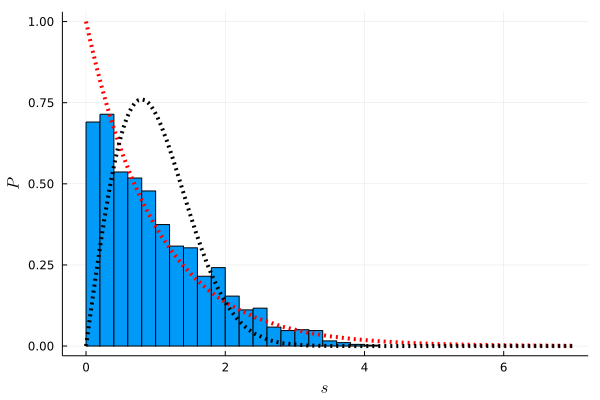

In [28]:
p2 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p2, new_diffs1, bins=:auto, normed=true)
plot!(p2, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p2, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

#### Case 2. $\gamma=1.5$

In [29]:
eigs2 = eigvals(Htot(γ=1.5, J=J, g=g, d=d, C6=C6, R=R));

In [30]:
diffs2 = [eigs2[i+1]-eigs2[i] for i in 1:length(eigs2)-1];

In [31]:
index12 = Int((v-1)/2)
index22 = length(diffs2)-index12
diffs2_dropped = diffs2[index12:index22];

In [32]:
new_diffs2 = []
for i in 1:length(diffs2_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs2_dropped)
        append!(new_diffs2, diffs2_dropped[i]/average_spacing(diffs2_dropped, i, v))
    end
end

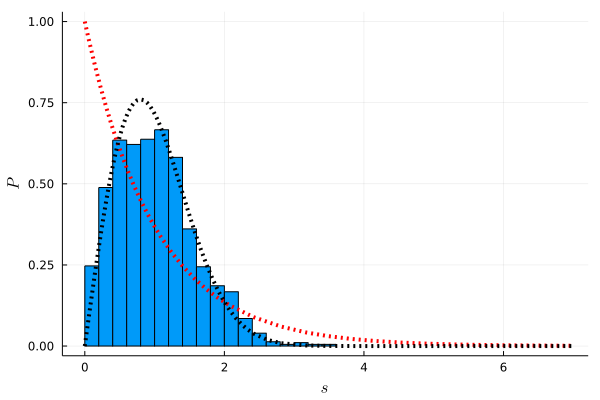

In [33]:
p3 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p3, new_diffs2, bins=:auto, normed=true)
plot!(p3, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p3, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

#### Case 3. $\gamma=10$

In [34]:
eigs3 = eigvals(Htot(γ=10.0, J=J, g=g, d=d, C6=C6, R=R));

In [35]:
diffs3 = [eigs3[i+1]-eigs3[i] for i in 1:length(eigs3)-1];

In [36]:
index13 = Int((v-1)/2)
index23 = length(diffs3)-index13
diffs3_dropped = diffs3[index13:index23];

In [37]:
new_diffs3 = []
for i in 1:length(diffs3_dropped)
    drop_index = Int((v-1)/2)
    if i-drop_index>0 && i+drop_index<=length(diffs3_dropped)
        append!(new_diffs3, diffs3_dropped[i]/average_spacing(diffs3_dropped, i, v))
    end
end

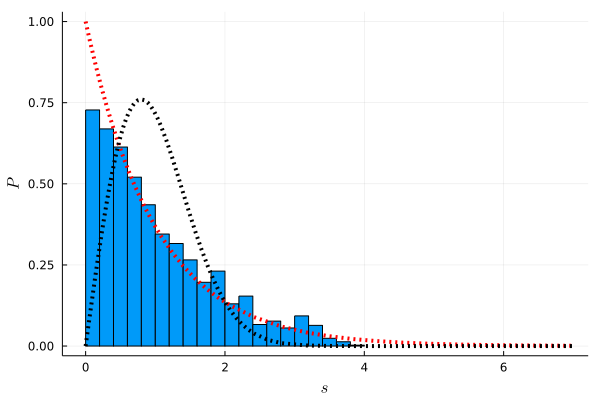

In [38]:
p4 = plot(xlab=L"$s$", ylab=L"$P$", legend=false)
histogram!(p4, new_diffs3, bins=:auto, normed=true)
plot!(p4, f, 0, 7, linestyle=:dot, linewidth=4, color=:red)
plot!(p4, ff, 0, 7, linestyle=:dot, linewidth=4, color=:black)

In [39]:
# # Glue everything together
# fig = Figure()
# ax1 = Axis(fig[1,1])
# ax2 = Axis(fig[1,2])
# ax3 = Axis(fig[1,3])

# hist(ax1, new_diffs1)


### Conclusion of change of $\gamma$
1. As $\gamma$ increases, chaos emerges as the level distritution turns into Wigner distribution.
2. What I found out that if I set $\Lambda_1$ larger than 1, then the nice Wigner distribution as listed here will disappear no matter how I change $\gamma$. I think this is because if the system has strong neareast-neighbour interactions, then such system will self-trap itself in certain state, therefore no matter how I change the tilting potential, I will not change much of the state of the system.

### Entanglement entropy and entanglement spectrum
We will first consider the entanglement spectrum for the ground state of the system. When we try to calculate the reduced density matrix, we will bipartite the system into two subsystems each containing 1 and 2 sites and we will trace out the 1 site subsystem.

In [40]:
function EE(; γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64, Na::Int64)
    vec = eigvecs(Htot(γ=γ, J=J, g=g, d=d, C6=C6, R=R))[:,1]
    rdmat = reduced_density_matrix(state=vec, Na=Na, Ls=Ls, Rd=1)
    vals = svd(rdmat).S
    EE = -transpose(vals)*log.(vals)
    return EE
end

EE (generic function with 1 method)

In [41]:
# I now only makes this function works given the initial state with equal
# number of atoms in each site. But I potentially can extend it to arbitrary initial state.
function evolEE(;H::Matrix{Float64},t::Float64,basis::Vector{Vector{Int64}},init::Vector{Int})
    
    if t == 0.0
        EE = 0.0
    else
        vec = state_evolution(H=H,t=t,basis=basis,init=init)
        #rdmat = reduced_density_matrix(Na=Na, state=vec, Hbs=Hbs)
        rdmat = reduced_density_matrix(state=vec, Na=Na, Ls=Ls, Rd=1)
        vals = svd(rdmat).S
        #EE = -transpose(conj(vals).*vals)*log.(conj(vals).*(vals))
        #vals_squd = vals.*conj(vals)
        EE = -transpose(vals)*log.(vals)
    end
    
    return EE
end

evolEE (generic function with 1 method)

In [42]:
function evolEE_random(;H::Matrix{Float64},t::Float64,basis::Vector{Vector{Int64}},init::Vector{Float64})
    
    if t == 0.0
        rdmat = reduced_density_matrix(state=init, Na=Na, Ls=Ls, Rd=1)
        vals = svd(rdmat).S
        EE = -transpose(vals)*log.(vals)
    else
        vec = state_evolution_random(H=H,t=t,basis=basis,init=init)
        #rdmat = reduced_density_matrix(Na=Na, state=vec, Hbs=Hbs)
        rdmat = reduced_density_matrix(state=vec, Na=Na, Ls=Ls, Rd=1)
        vals = svd(rdmat).S
        #EE = -transpose(conj(vals).*vals)*log.(conj(vals).*(vals))
        #vals_squd = vals.*conj(vals)
        EE = -transpose(vals)*log.(vals)
    end
    
    return EE
end

evolEE_random (generic function with 1 method)

In [108]:
H0 = Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R);
H1 = Htot(γ=1.0, J=J, g=g, d=d, C6=C6, R=R);
H15 = Htot(γ=1.5, J=J, g=g, d=d, C6=C6, R=R);
H2 = Htot(γ=2.0, J=J, g=g, d=d, C6=C6, R=R);
H3 = Htot(γ=3.0, J=J, g=g, d=d, C6=C6, R=R);
H4 = Htot(γ=4.0, J=J, g=g, d=d, C6=C6, R=R);
H6 = Htot(γ=6.0, J=J, g=g, d=d, C6=C6, R=R);
H7 = Htot(γ=7.0, J=J, g=g, d=d, C6=C6, R=R);
H8 = Htot(γ=8.0, J=J, g=g, d=d, C6=C6, R=R);
H9 = Htot(γ=9.0, J=J, g=g, d=d, C6=C6, R=R);
H10 = Htot(γ=10.0, J=J, g=g, d=d, C6=C6, R=R);

In [151]:
ts = 1.0:0.05:20.0

1.0:0.05:20.0

In [44]:
# EE0 = EE(γ=0.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
# EE1 = EE(γ=1.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
# EE3 = EE(γ=3.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
# EE4 = EE(γ=4.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);
# EE10 = EE(γ=10.0, J=J, g=g, d=d, C6=C6, R=R, Na=Na);

In [81]:
ts = 0.0:0.2:10;

In [82]:
@time evolEE0s = [evolEE(H=H0,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts]

300.263290 seconds (190.45 M allocations: 34.064 GiB, 0.40% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 2.846179600101717
 3.522285700838719
 3.797772402222237
 3.864345652384973
 3.897111697864711
 3.881766143725927
 3.8667794116296914
 3.8277926346275937
 3.7687334845563933
 3.759901274582897
 3.7524409368092417
 3.779521594664362
 ⋮
 3.78958204889774
 3.841320228826056
 3.871343359762716
 3.8753915380110575
 3.8662920639547753
 3.8231806506750248
 3.7949738746877353
 3.794876004444707
 3.8069747297219623
 3.821730791596958
 3.8692913291993447
 3.877334046749572

In [83]:
@time evolEE2s = [evolEE(H=H2,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts]

309.324754 seconds (190.45 M allocations: 34.064 GiB, 0.38% gc time, 0.02% compilation time)


51-element Vector{Float64}:
 0.0
 2.8392012458568825
 3.5053142857203903
 3.7773042736571285
 3.8727299918255493
 3.896247503451854
 3.918001492717801
 3.927790944390639
 3.89515729187407
 3.863818292826515
 3.892072513301888
 3.8763037089096692
 3.8266628128579643
 ⋮
 3.8884101655583265
 3.8859977626496343
 3.8749421982798777
 3.8498782539207728
 3.828622511795716
 3.828405870745031
 3.87012943507514
 3.9330194411790185
 3.9535345641293853
 3.9552146804533512
 3.955847289987995
 3.9336897096096735

In [84]:
@time evolEE4s = [evolEE(H=H4,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts]

329.765735 seconds (190.45 M allocations: 34.064 GiB, 0.37% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 2.820402517245107
 3.436961362005702
 3.667949940745753
 3.7903701023917864
 3.806631721756432
 3.7928656223130233
 3.6827659447097236
 3.500939784727028
 3.50222559301495
 3.4496639911574367
 3.38191725399241
 3.5486790201248137
 ⋮
 3.678704473102644
 3.643053497027292
 3.638951318603943
 3.6260387664147764
 3.6660890163966107
 3.7009845859726305
 3.75628552515044
 3.7961196078104456
 3.775894979069218
 3.7560735171986868
 3.706883259679831
 3.6373335185759665

In [85]:
@time evolEE6s = [evolEE(H=H6,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts]

328.015086 seconds (190.45 M allocations: 34.064 GiB, 0.37% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 2.7899844202121464
 3.3216163952869913
 3.4671655696264274
 3.413276187142638
 3.2154307729031117
 2.8382695408557916
 3.039437566362161
 3.3240521337027022
 3.494910186609536
 3.5049729491384918
 3.392051343013048
 3.4051681716977917
 ⋮
 3.4656527742117165
 3.452722083001774
 3.4240969553571574
 3.4222268693714906
 3.4752360134614753
 3.466099461039094
 3.449596308731992
 3.3930104219956725
 3.4012314381316657
 3.473608692640571
 3.474667030672758
 3.4813136208602984

In [86]:
# prepend!(evolEE0s,EE0);
# prepend!(evolEE1s,EE1);
# prepend!(evolEE3s,EE3);
# prepend!(evolEE4s,EE4);
# prepend!(evolEE10s,EE10);

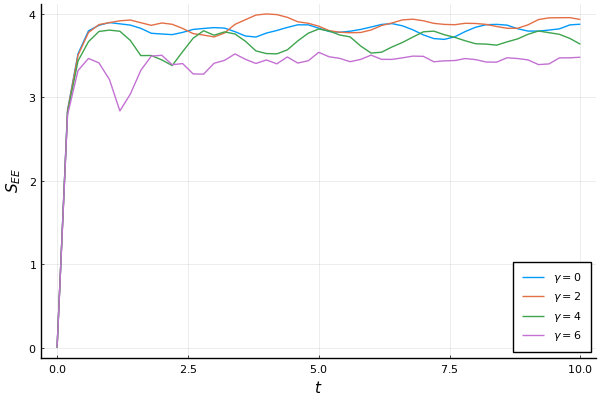

In [87]:
eplot = plot(ylab=L"$S_{EE}$", xlab=L"$t$", legend=:bottomright)
plot!(eplot, ts, evolEE0s, label=L"$\gamma=0$")
#plot!(eplot, ts, evolEE1s, label=L"$\gamma=1$")
plot!(eplot, ts, evolEE2s, label=L"$\gamma=2$")
plot!(eplot, ts, evolEE4s, label=L"$\gamma=4$")
plot!(eplot, ts, evolEE6s, label=L"$\gamma=6$")

We will next study how the average entanglement entropy reacts to $\gamma$. The logic is I will evolve reduced density matrices at different $\gamma$'s, then calculate the average of EE's.

In [90]:
gammas = 0.0:1:10
ts1 = 0.0:0.3:5.0
aveEEs = zeros(Float64, 1, length(gammas))
std_ee = zeros(Float64, 1, length(gammas))
@time for i in 1:length(gammas)
    gamma = gammas[i]
    H = Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R)
    evolEEs = [evolEE(H=H,t=t,basis=Hbs,init=vec([20 20 20])) for t in ts1]
    len = length(evolEEs)
    drop_rate = 0.2 # we drop the first 20% of data
    left_num = Int(floor(drop_rate*len))
    aveEEs[i] = mean(evolEEs[left_num:len])
    std_ee[i] = std(evolEEs[left_num:len])
    display(aveEEs)
end

1×11 Matrix{Float64}:
 3.81213  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  3.64568  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.54515  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.54515  3.3667  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.3667  3.16806  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.3667  3.16806  2.96975  0.0  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.16806  2.96975  2.86149  0.0

1×11 Matrix{Float64}:
 3.81213  3.89325  3.87595  3.73886  …  3.16806  2.96975  2.86149  2.73897

1099.927662 seconds (865.39 M allocations: 126.030 GiB, 0.39% gc time, 0.00% compilation time)


In [93]:
scatter_ee = plot(legend=false, ylab=L"$\bar{S}_{EE}$", xlab=L"$\gamma$")
scatter!(scatter_ee, gammas, aveEEs', yerror=std_ee');

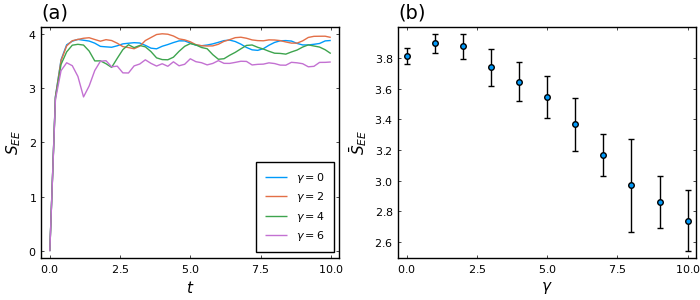

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [94]:
letters = reshape(collect('a':'b'), (1,2))
p1 = plot(eplot, scatter_ee, layout=(1,2), size=(700,300), framestyle=:box, grid=false, title=["($(letters[i]))" for j in 1:1, i in 1:2], titleloc=:left, textsize=16, font="CMU Serif")


In [55]:
savefig(p1, "./pics/p1.png")

### Here we will consider the state [60, 0, 0]

In [59]:
@time evolEE0s_new = [evolEE(H=H0,t=t,basis=Hbs,init=vec([60 0 0])) for t in ts]

475.786235 seconds (190.45 M allocations: 34.064 GiB, 0.22% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 1.7712732433046483
 2.417645010797591
 2.752379862895886
 3.005924620632876
 3.2277066809012736
 3.4234754406815164
 3.587341828126128
 3.7018675794849516
 3.741998609502608
 3.7109560847529846
 3.6650705094989013
 3.6305637404025513
 ⋮
 3.643671242894171
 3.893787308707545
 3.975044958463349
 3.8506044809450195
 3.7983377474380737
 3.9221322411766275
 3.9782472943934186
 3.929808208409277
 3.877392427153146
 3.8660708857014265
 3.863565586310954
 3.8590575259590048

In [60]:
@time evolEE2s_new = [evolEE(H=H2,t=t,basis=Hbs,init=vec([60 0 0])) for t in ts]

410.402609 seconds (190.45 M allocations: 34.064 GiB, 0.26% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 1.7829955377454558
 2.434638601369599
 2.710969127985181
 2.759778405168591
 2.5044292194895377
 2.0440737138586704
 2.4799842767095353
 2.8821081350521016
 3.026265385806613
 3.047539986575279
 2.9754727818959363
 2.7324465524000505
 ⋮
 3.273464977482872
 2.9394395630724066
 2.948200085652367
 3.4664587894501118
 3.714060494463795
 3.5852751234935427
 3.186214952301146
 2.892399168048347
 2.9398533679746928
 3.3230952869612795
 3.682460805898666
 3.868840644384543

In [61]:
@time evolEE4s_new = [evolEE(H=H4,t=t,basis=Hbs,init=vec([60 0 0])) for t in ts]

394.409501 seconds (190.45 M allocations: 34.064 GiB, 0.26% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 1.7803095511510532
 2.404115543175771
 2.5767349389372836
 2.440270473370349
 2.3296964709896284
 2.5095774569575746
 2.4964130423129074
 2.1345675610833363
 0.9046870399815691
 1.1558007862801032
 2.221226804142374
 2.5711145665493174
 ⋮
 2.107234637687201
 2.588823766407077
 2.7023969932273744
 2.4697562989525688
 2.2395666242244574
 2.4959068644963853
 2.4379435234858677
 1.9564244213623527
 0.4418321794040545
 1.6521751981711699
 2.475200448020064
 2.728201202365303

In [62]:
@time evolEE6s_new = [evolEE(H=H6,t=t,basis=Hbs,init=vec([60 0 0])) for t in ts]

468.686431 seconds (190.45 M allocations: 34.064 GiB, 0.23% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 1.7632723874901135
 2.331708644405713
 2.417609421702647
 2.30767669560634
 2.1974191186894787
 1.7939303387231615
 0.15792418935826588
 1.7619648009962938
 2.462298673205887
 2.5308654419583383
 2.219446566277713
 2.0897865453467066
 ⋮
 2.280232441620592
 2.1495614079114533
 2.360030079039801
 1.6600954031251915
 1.4993483401508108
 2.670107299533799
 2.8946889023819606
 2.3636861886090417
 2.1823352743790414
 2.432122150517833
 1.8710672571693066
 1.5086784399081556

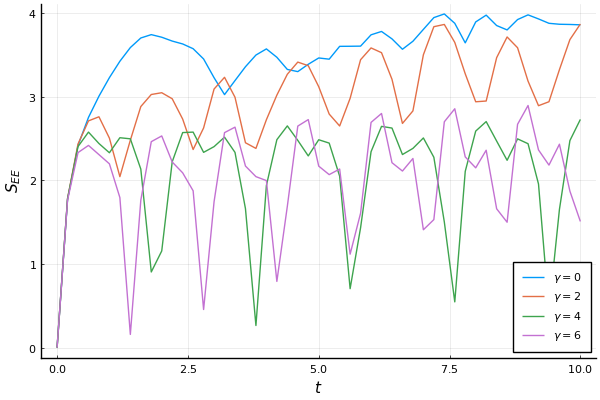

In [63]:
eplot_new = plot(ylab=L"$S_{EE}$", xlab=L"$t$", legend=:bottomright)
plot!(eplot_new, ts, evolEE0s_new, label=L"$\gamma=0$")
#plot!(eplot, ts, evolEE1s, label=L"$\gamma=1$")
plot!(eplot_new, ts, evolEE2s_new, label=L"$\gamma=2$")
plot!(eplot_new, ts, evolEE4s_new, label=L"$\gamma=4$")
plot!(eplot_new, ts, evolEE6s_new, label=L"$\gamma=6$")

In [70]:
gammas = 0.0:1:10
ts1 = 0.0:0.3:5.0
aveEEs_new = zeros(Float64, 1, length(gammas))
std_new = zeros(Float64, 1, length(gammas))
@time for i in 1:length(gammas)
    gamma = gammas[i]
    H = Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R)
    evolEEs = [evolEE(H=H,t=t,basis=Hbs,init=vec([60 0 0])) for t in ts1]
    len = length(evolEEs)
    drop_rate = 0.2 # we drop the first 20% of data
    left_num = Int(floor(drop_rate*len))
    aveEEs_new[i] = mean(evolEEs[left_num:len])
    std_new[i] = std(evolEEs[left_num:len])
    display(aveEEs_new)
end

1×11 Matrix{Float64}:
 3.39405  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  2.1866  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  2.1866  2.04992  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  2.1866  …  2.01557  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  …  2.01557  1.78524  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  …  2.01557  1.78524  1.72579  0.0  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  …  1.78524  1.72579  1.57704  0.0

1×11 Matrix{Float64}:
 3.39405  2.65939  2.82329  2.35274  …  1.78524  1.72579  1.57704  1.45065

1782.930102 seconds (866.73 M allocations: 126.102 GiB, 0.25% gc time, 0.02% compilation time)


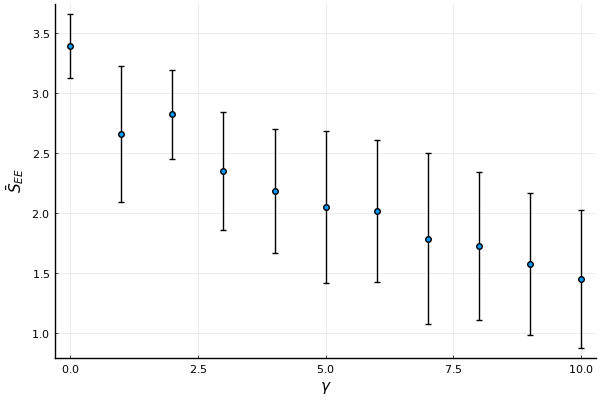

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [78]:
scatter_ee_new = plot(legend=false, ylab=L"$\bar{S}_{EE}$", xlab=L"$\gamma$")
scatter!(scatter_ee_new, gammas, aveEEs_new', yerror=std_new');
scatter_ee_new

### Here we will consider the case [0,0,60]

In [64]:
@time evolEE0s_newnew = [evolEE(H=H0,t=t,basis=Hbs,init=vec([0 0 60])) for t in ts]

334.423927 seconds (190.45 M allocations: 34.064 GiB, 0.32% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 0.11021693952872523
 0.7344110213565236
 1.5178734167394352
 2.0676762743650645
 2.455073976367161
 2.776910275243405
 3.0740765940979236
 3.3506662023154186
 3.5709292495792893
 3.665713900342449
 3.5720139571102463
 3.259462960404064
 ⋮
 3.4101689144357596
 3.3686718358539403
 3.40962404958354
 3.5272201815353004
 3.576150174738882
 3.6286320296657686
 3.5731615052704395
 3.5497509157250957
 3.7030187131110215
 3.817519156266032
 3.8814660698444854
 3.8646979710334595

In [65]:
@time evolEE2s_newnew = [evolEE(H=H2,t=t,basis=Hbs,init=vec([0 0 60])) for t in ts]

322.191048 seconds (190.45 M allocations: 34.064 GiB, 0.33% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 0.1090937213683783
 0.7078505679053937
 1.4200317694910944
 1.8726981085416532
 2.1148693582447815
 2.2220268295581618
 2.2145301301611244
 2.075334361121009
 1.7720764672826828
 1.3484974777141783
 1.1266563055949914
 1.1414964315683331
 ⋮
 2.19628499020214
 1.8425374605113796
 1.4282229127186528
 1.3909096502401406
 1.3943599117982637
 1.3009962188708883
 1.2300632612706357
 1.4005020140724886
 1.7491148213251544
 2.0344937995775796
 2.20301751793688
 2.273257170062945

In [66]:
@time evolEE4s_newnew = [evolEE(H=H4,t=t,basis=Hbs,init=vec([0 0 60])) for t in ts]

315.503653 seconds (190.45 M allocations: 34.064 GiB, 0.35% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 0.10346463026679074
 0.5953677278998825
 1.048435169129919
 1.1801900393763103
 1.0986108702722126
 1.1820240942245188
 1.4596462488067292
 1.570679754368813
 1.4247686679021978
 1.1479854556166407
 1.1170520692799
 1.1855603472530714
 ⋮
 1.5067964895763741
 1.5492336985792794
 1.335515394768258
 1.107889078683715
 1.1532439814799138
 1.1833132885330435
 0.9077241598695294
 0.3602322091488158
 0.07718981224488558
 0.07442988939471074
 0.3454009605471967
 0.8263048023024204

In [67]:
@time evolEE6s_newnew = [evolEE(H=H6,t=t,basis=Hbs,init=vec([0 0 60])) for t in ts]

318.890582 seconds (190.45 M allocations: 34.064 GiB, 0.38% gc time, 0.01% compilation time)


51-element Vector{Float64}:
 0.0
 0.0939020011643038
 0.4240335679204288
 0.51485730190202
 0.47853417517420865
 0.7253172390099059
 0.7246252577519035
 0.44521919965011236
 0.44022665689022733
 0.35831008007633663
 0.08383852440533526
 0.03475695927882582
 0.12844859559538743
 ⋮
 0.6429371852534902
 0.3280051307623213
 0.2400064818278438
 0.19309829265669137
 0.18426325970110524
 0.27194499415000495
 0.2859603643407608
 0.5936797953382309
 0.6974114391451618
 0.5228621898282629
 0.6074794823785076
 0.6000163583689093

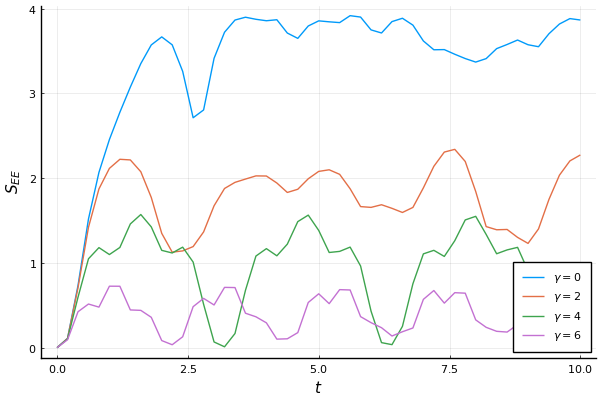

In [68]:
eplot_newnew = plot(ylab=L"$S_{EE}$", xlab=L"$t$", legend=:bottomright)
plot!(eplot_newnew, ts, evolEE0s_newnew, label=L"$\gamma=0$")
#plot!(eplot, ts, evolEE1s, label=L"$\gamma=1$")
plot!(eplot_newnew, ts, evolEE2s_newnew, label=L"$\gamma=2$")
plot!(eplot_newnew, ts, evolEE4s_newnew, label=L"$\gamma=4$")
plot!(eplot_newnew, ts, evolEE6s_newnew, label=L"$\gamma=6$")

In [79]:
gammas = 0.0:1:10
ts1 = 0.0:0.3:5.0
aveEEs_newnew = zeros(Float64, 1, length(gammas))
std_newnew = zeros(Float64, 1, length(gammas))
@time for i in 1:length(gammas)
    gamma = gammas[i]
    H = Htot(γ=gamma, J=J, g=g, d=d, C6=C6, R=R)
    evolEEs = [evolEE(H=H,t=t,basis=Hbs,init=vec([0 0 60])) for t in ts1]
    len = length(evolEEs)
    drop_rate = 0.2 # we drop the first 20% of data
    left_num = Int(floor(drop_rate*len))
    aveEEs_newnew[i] = mean(evolEEs[left_num:len])
    std_newnew[i] = std(evolEEs[left_num:len])
    display(aveEEs_newnew)
end

1×11 Matrix{Float64}:
 3.27068  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  0.0  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  1.02509  0.0  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  …  0.734328  0.0  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  1.02509  …  0.408242  0.0  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  …  0.408242  0.263263  0.0  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  1.02509  …  0.263263  0.159944  0.0  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  …  0.263263  0.159944  0.0978178  0.0

1×11 Matrix{Float64}:
 3.27068  2.38979  1.77068  1.30665  …  0.159944  0.0978178  0.0672127

1151.599030 seconds (865.39 M allocations: 126.030 GiB, 0.41% gc time, 0.00% compilation time)


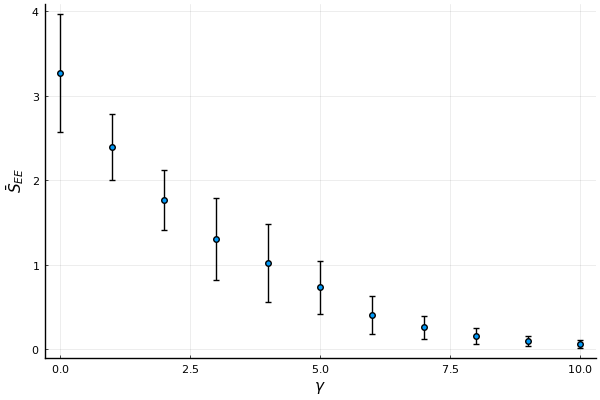

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [80]:
scatter_ee_newnew = plot(legend=false, ylab=L"$\bar{S}_{EE}$", xlab=L"$\gamma$")
scatter!(scatter_ee_newnew, gammas, aveEEs_newnew', yerror=std_newnew');
scatter_ee_newnew

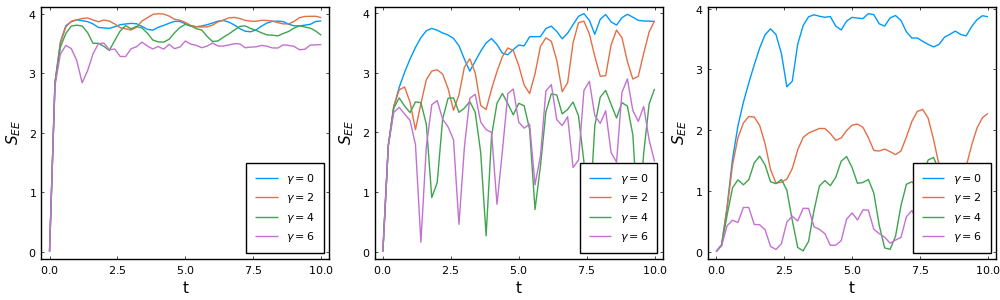

In [136]:
## Glue everything together
letters_newnew = reshape(collect('a':'f'), (1,6))
p2 = plot(eplot, eplot_new, eplot_newnew, scatter_ee, scatter_ee_new, scatter_ee_newnew, link=:x,
    layout=(2,3), size=(1000,600), framestyle=:box, grid=false,
    title=["($(letters_newnew[i]))" for j in 1:1, i in 1:6], titleloc=:left, textsize=16, font="CMU Serif")

In [1]:
fig = Figure()
ax1 = Axis(fig[1, 1])
ax2 = Axis(fig[1, 2])

LoadError: UndefVarError: Figure not defined

## The quench dynamics
We here will study here how a system in zero tilting potential will behave under a quench to higher tilting potential (i.e., chaotic region or non-chaotic region). The initial state is considered as the ground state when $\gamma=0$, then at $t=0$ we will change $\gamma$ to 4 to study the quench dynamics.

In [62]:
H = Htot(γ=0.0, J=J, g=g, d=d, C6=C6, R=R);

In [63]:
state_evolution(H=Htot(γ=2.5, J=J, g=g, d=d, C6=C6, R=R),t=0.5,basis=Hbs,init=vec([20 20 20]));

## Shannon Entropy

In [64]:
H = Htot(γ=4.0, J=J, g=g, d=d, C6=C6, R=R);
vals = eigvals(H);
vecs = eigvecs(H);

In [65]:
function α(;m::Int64, t::Float64, vals::Vector{Float64}, vecs::Matrix{Float64}, basis::Vector{Vector{Int64}}, init::Vector{Int64})
    ind = findall(x->x==init, basis)[1]
    Cvec = vecs[m,:]
    α = 0
    for j in 1:length(Cvec)
        pj = conj(vecs[ind,j])
        E_j = vals[j]
        α += pj*exp(-1im*E_j*t)*Cvec[j]
    end
    return α
end
    

α (generic function with 1 method)

In [66]:
function SB(;t::Float64, vals::Vector{Float64}, vecs::Matrix{Float64}, basis::Vector{Vector{Int64}}, init::Vector{Int64})
    SB = 0
    for i in 1:length(vals)
        αm = α(m=i, t=t, vals=vals, vecs=vecs, basis=Hbs, init=init)
        a = αm * conj(αm)
        SB += -a*log(a)
    end
    return SB
end

SB (generic function with 1 method)

In [67]:
ts = 0.1:0.2:5
SBs = zeros(Float64, 1, length(ts))
for i in 1:length(ts)
    SBs[i] = SB(t=ts[i], vals=vals, vecs=vecs, basis=Hbs, init=vec([20 20 20]))
end


In [68]:
p = plot(legend=false);

In [69]:
for i in 1:length(ts)
    scatter!(p, (ts[i], SBs[i]))
end

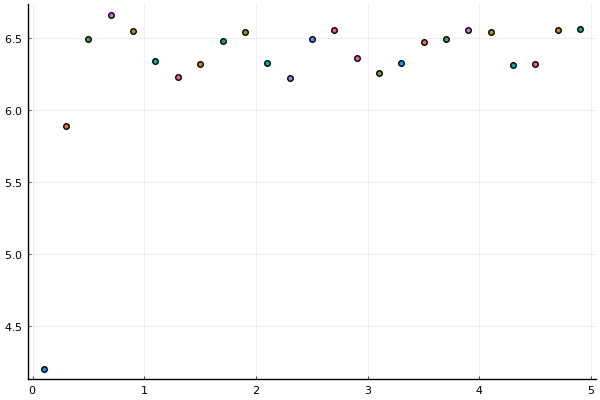

In [70]:
p